<a href="https://colab.research.google.com/github/RobertoAlessandri/CNN_DOA/blob/main/dataset_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [237]:
!pip3 install pyroomacoustics

In [238]:
# Imports
import os
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd 
import pyroomacoustics as pra
from scipy.io import wavfile
import math

In [239]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [240]:
%ls /content/drive/MyDrive/Github/CNN_DOA/TIMIT/TEST/DR1/FAKS0/

SA1.PHN  SA2.WAV     SI2203.PHN  SI943.WAV  SX223.PHN  SX313.WAV  SX43.PHN
SA1.TXT  SA2.WRD     SI2203.TXT  SI943.WRD  SX223.TXT  SX313.WRD  SX43.TXT
SA1.WAV  SI1573.PHN  SI2203.WAV  SX133.PHN  SX223.WAV  SX403.PHN  SX43.WAV
SA1.WRD  SI1573.TXT  SI2203.WRD  SX133.TXT  SX223.WRD  SX403.TXT  SX43.WRD
SA2.PHN  SI1573.WAV  SI943.PHN   SX133.WAV  SX313.PHN  SX403.WAV
SA2.TXT  SI1573.WRD  SI943.TXT   SX133.WRD  SX313.TXT  SX403.WRD


In [241]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [242]:
# Getting all WAV files's paths in TEST folder
dirName = '/content/drive/MyDrive/Github/CNN_DOA/TIMIT/TEST';
listOfFiles = getListOfFiles(dirName)
listOfTestWavs = list()
for fileName in listOfFiles:
  if fileName.endswith('.WAV'):
    listOfTestWavs.append(fileName)

print("{} WAV files found!".format(len(listOfTestWavs)))
print("Eg.\n {} \n {} \n {}".format(listOfTestWavs[0], listOfTestWavs[1000], listOfTestWavs[1600]))

1680 WAV files found!
Eg.
 /content/drive/MyDrive/Github/CNN_DOA/TIMIT/TEST/DR7/MRMS1/SA1.WAV 
 /content/drive/MyDrive/Github/CNN_DOA/TIMIT/TEST/DR5/MDAC2/SA1.WAV 
 /content/drive/MyDrive/Github/CNN_DOA/TIMIT/TEST/DR4/MLJB0/SA1.WAV


In [243]:
# Getting all WAV files's paths in TRAIN folder
dirName = '/content/drive/MyDrive/Github/CNN_DOA/TIMIT/TRAIN';
listOfFiles = getListOfFiles(dirName)
listOfTrainWavs = list()
for fileName in listOfFiles:
  if fileName.endswith('.WAV'):
    listOfTrainWavs.append(fileName)

print("{} WAV files found!".format(len(listOfTrainWavs)))
print("Eg.\n {} \n {} \n {}".format(listOfTrainWavs[0], listOfTrainWavs[1000], listOfTrainWavs[3000]))

3095 WAV files found!
Eg.
 /content/drive/MyDrive/Github/CNN_DOA/TIMIT/TRAIN/DR4/MMDM0/SA1.WAV 
 /content/drive/MyDrive/Github/CNN_DOA/TIMIT/TRAIN/DR3/FGCS0/SA1.WAV 
 /content/drive/MyDrive/Github/CNN_DOA/TIMIT/TRAIN/DR7/MRPC1/SA1.WAV


## Test files

In [244]:
def getAudioMatrix(paths, duration, numOfWavs):
  sr = librosa.load(paths[0], sr=None)[1]
  sample_duration = int(duration*sr);

  audioMatrix = np.zeros([sample_duration, numOfWavs])
  i = 0
  for wavPath in paths[:numOfWavs]:
    x, sr = librosa.load(wavPath, sr=None)
    x = x[0:sample_duration]
    #x = x.reshape(len(x), 1)  
    audioMatrix[0:sample_duration, i] = x
    i += 1
    

  return audioMatrix, sr

In [245]:
sourcesNum = 10
testAudioMatrix, sr = getAudioMatrix(listOfTestWavs, 2, sourcesNum)

# TODO: plot some files using time axis in seconds
sr

16000

In [246]:
ipd.Audio(testAudioMatrix[:,0], rate=sr)

## ROOM simulation

0.4591998263681843 37


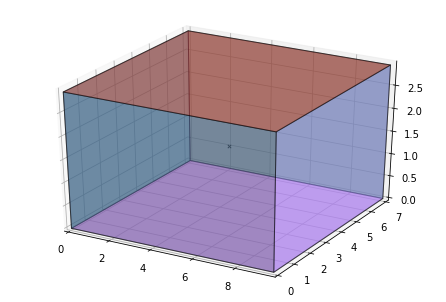

In [260]:
# Desired reverberation time and dimensions of the room
rt60 = 0.3  # seconds
room_dim = [9.64, 7.04, 2.95]  # meters
fs = sr # the sampling frequency should match that of the room

# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60, room_dim)

print(e_absorption, max_order)

# Create the room
room = pra.ShoeBox(
    room_dim, fs=sr,  materials=pra.Material(e_absorption), max_order=max_order
)

# place the mics in the room
mic_center = [room_dim[0]/2, room_dim[1]/2, 1.5]
mic_radius = 0.04 / 2
mic_locs = np.matrix([
    [mic_center[0] + mic_radius, mic_center[1], mic_center[2]],  # mic 1
    [mic_center[0], mic_center[1] + mic_radius, mic_center[2]],  # mic 2
    [mic_center[0] - mic_radius, mic_center[1], mic_center[2]],  # mic 3
    [mic_center[0], mic_center[1] - mic_radius, mic_center[2]],  # mic 4
])

mic_locs = mic_locs.T

room.add_microphone_array(mic_locs)

fig, ax = room.plot()
ax.set_xlim([0, room_dim[0]])
ax.set_ylim([0, room_dim[1]])
ax.set_zlim([0, room_dim[2]]);

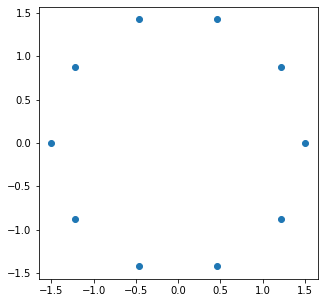

In [248]:
# TEST CIRCLE
subdivs = sourcesNum
deltaTheta = 2 * math.pi / subdivs
theta = np.arange(0, 2*math.pi, deltaTheta)
radius = 1.5

x = np.zeros([subdivs, 1])
y = np.zeros([subdivs, 1])
for i in np.arange(0,subdivs):
  x[i] = radius * math.cos(theta[i])
  y[i] = radius * math.sin(theta[i])



plt.figure(figsize=(5,5))
plt.scatter(x, y)
plt.show()

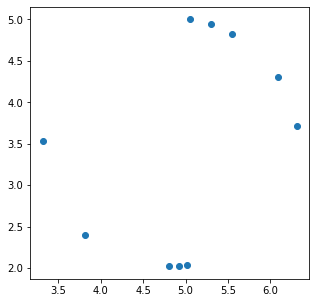

In [249]:
np.random.seed(10)
randomThetas = np.random.rand(subdivs) * 2 * math.pi

x = np.zeros([subdivs, 1])
y = np.zeros([subdivs, 1])
for i in np.arange(0,subdivs):
  x[i] = radius * math.cos(randomThetas[i]) + mic_center[0]
  y[i] = radius * math.sin(randomThetas[i]) + mic_center[1]


plt.figure(figsize=(5,5))
plt.scatter(x, y)
plt.show()

In [250]:
testDOAs = randomThetas * 180 / np.pi
testDOAs

array([277.67543158,   7.47070177, 228.11336457, 269.56939771,
       179.46252443,  80.92679239,  71.30263131, 273.79105639,
        60.87990116,  31.8023331 ])

In [251]:
def startSimulation(room, audio, sourcePosition):
  # Remove the previous source
  room.sources.pop()

  # place the source in the room
  room.add_source(sourcePosition, signal=audio)

  # Run the simulation (this will also build the RIR automatically)
  room.simulate()

  return np.transpose(room.mic_array.signals)

In [252]:
#Simulating for each source

#First iteration out of the loop
room.add_source([x[0][0], y[0][0], 1.5], signal=testAudioMatrix[:, 0])
room.simulate()

simulatedTest = np.zeros([len(room.mic_array.signals[0, :]), 4, sourcesNum])
simulatedTest[:,:,0] = np.transpose(room.mic_array.signals)

In [253]:
for i in np.arange(1, sourcesNum):
  simulatedTest[:,:, i] = startSimulation(room, testAudioMatrix[:, i], [x[i][0], y[i][0], 1.5])

In [266]:
for i in np.arange(0, sourcesNum):
  ipd.display(ipd.Audio(simulatedTest[:,0,i], rate=sr))
  #plt.figure()
  #plt.plot(simulatedTest[:,0,i])